# Here I'll be doing a qualitative test using nearest neighbors
- generate images with a trained model 
- find the nearest neighbor to that generated image in the training set 
- visually compare the generated image to its real image neighbor

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import Constraint
import argparse

FONTSIZE=18
plt.rcParams['figure.figsize']=(16,8)
plt.rcParams['font.size']=FONTSIZE

# Generate Many Images

In [27]:
generator=load_model('./results_boost10_clip0.001/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_WeightClip_0.001_Gen_epoch_750.h5')

In [28]:
def generate_latent_space(latent_dim,sample_size):
    '''
    latent_dim - size of the latent dimenstion
    sample_size - number of samples
    '''
    
    gen_input=np.random.randn(latent_dim*sample_size)
    gen_input=gen_input.reshape((sample_size,latent_dim))
    
    return gen_input

latent_space=generate_latent_space(latent_dim=20,sample_size=100)

In [29]:
generated_plots=generator.predict(latent_space)
print(generated_plots.shape)

(100, 96, 96, 4)


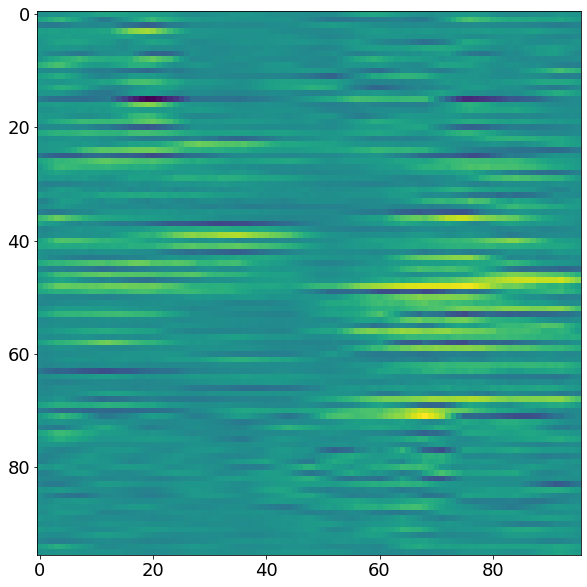

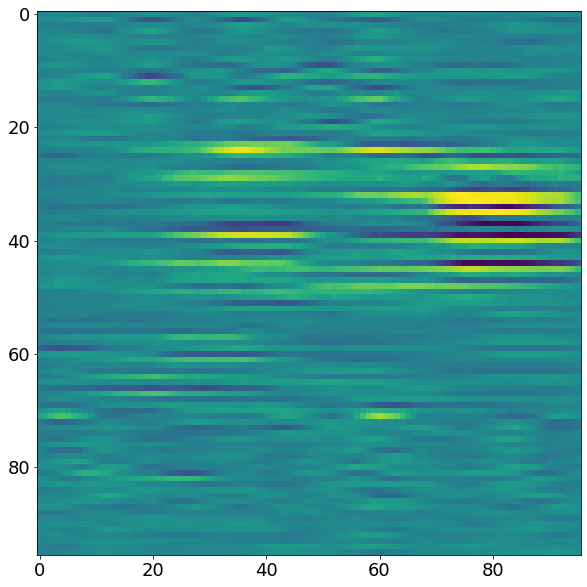

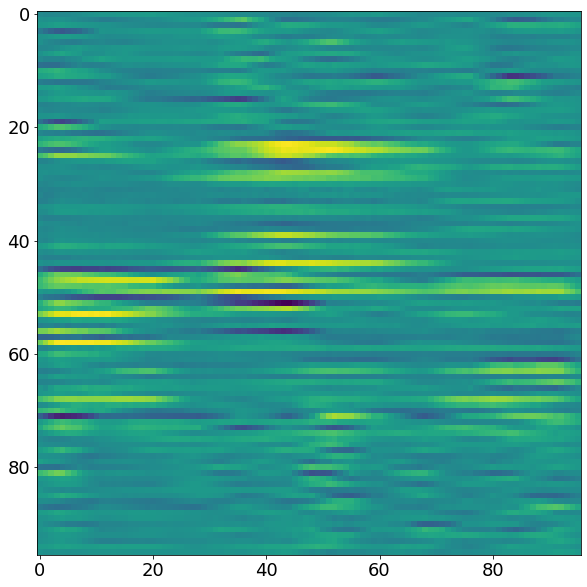

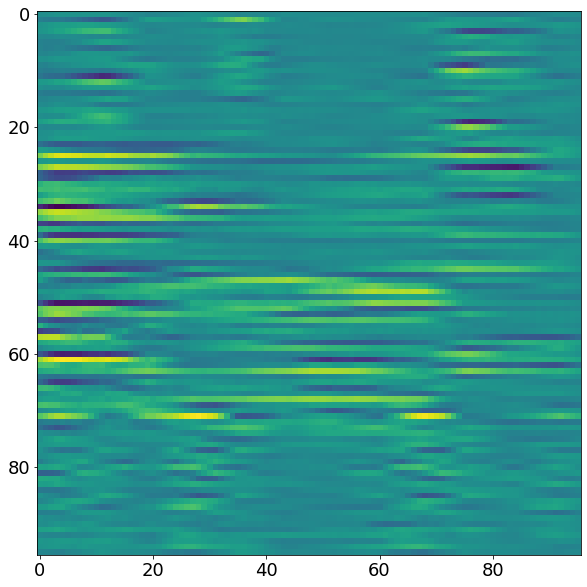

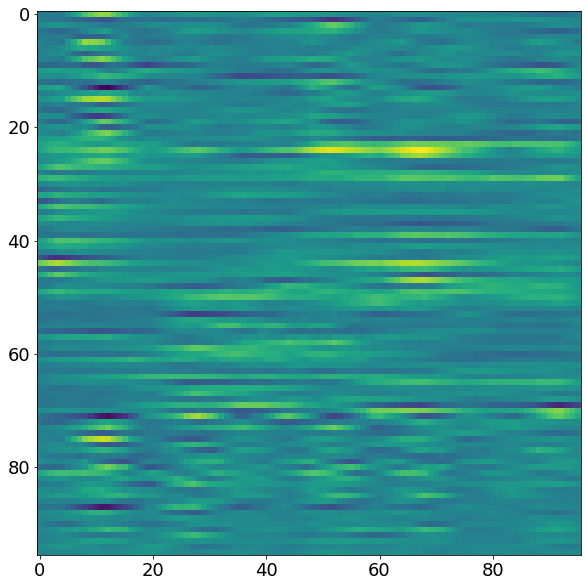

In [30]:
for i in range(5):
    plt.imshow(generated_plots[i,:,:,0].reshape((96,96)))
    plt.show()

# Let's adjust the images so only pixels above a set threshold are kept 
# every other pixel given a value of 0

In [31]:
def clip_plots(generated_plots,threshold=0.5):
    
    num_plots=generated_plots.shape[0]
    image_height=generated_plots.shape[1]
    image_width=generated_plots.shape[2]
    num_channels=generated_plots.shape[3]
    
    generated_plots_clipped=np.zeros((num_plots,image_height,image_width,num_channels))
    
    for i in range(num_plots):
        for j in range(image_height):
            for k in range(image_width):
                for m in range(num_channels):
                    
                    pixel_check=generated_plots[i,j,k,m]
                    
                    if pixel_check>threshold:
                        
                        generated_plots_clipped[i,j,k,m]=1
                        
    return generated_plots_clipped

generated_plots_clipped=clip_plots(generated_plots)

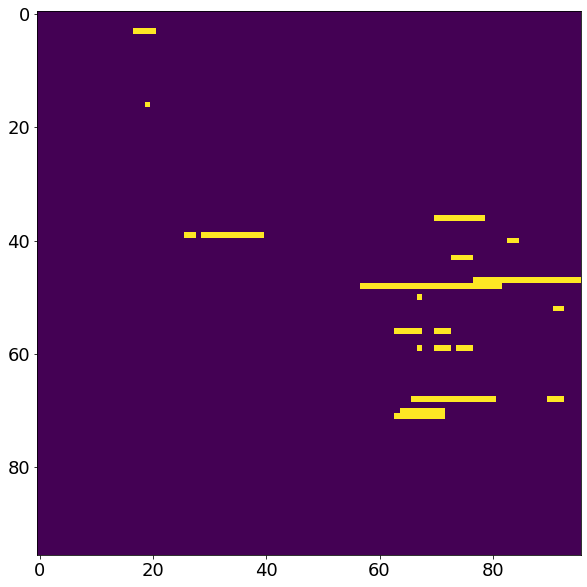

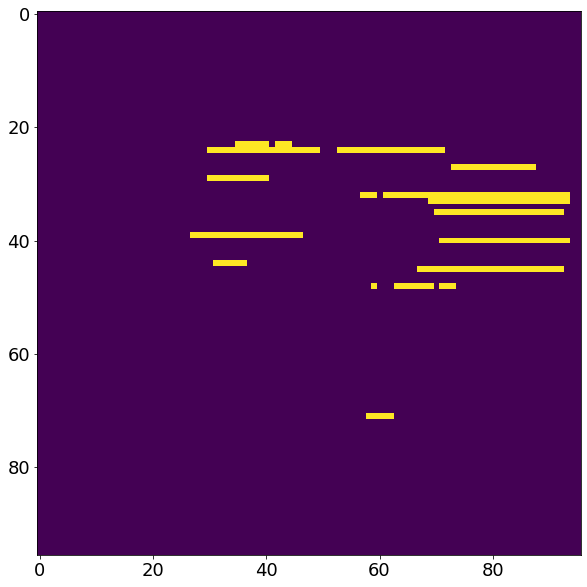

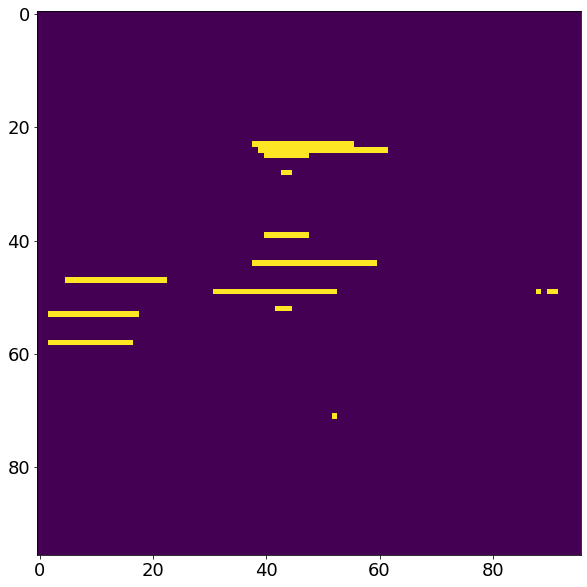

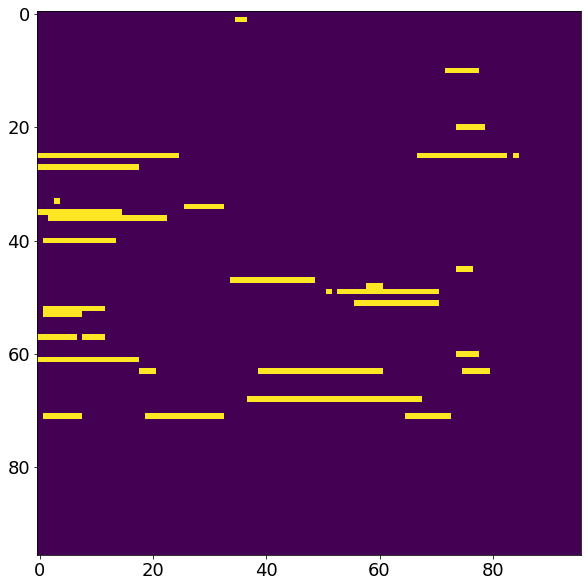

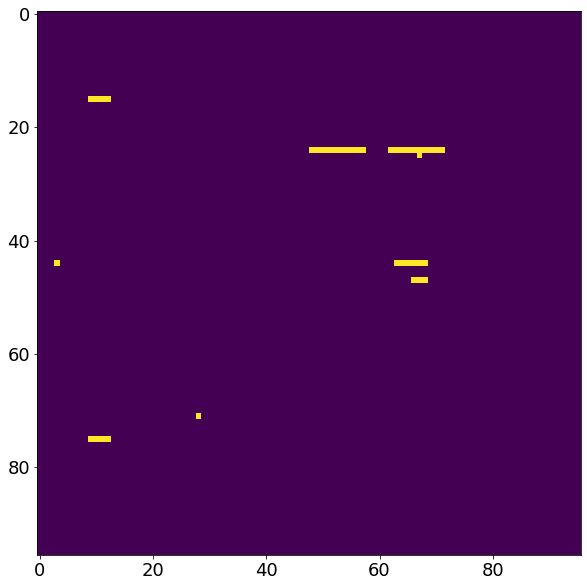

In [32]:
for i in range(5):
    plt.imshow(generated_plots_clipped[i,:,:,0].reshape((96,96)))
    plt.show()

# find nearest neighbor in training set for each generated image

In [33]:
fp = open('ins_convgan_final_fantasy_fifths.pkl', "rb")
ins = pickle.load(fp)
fp.close()

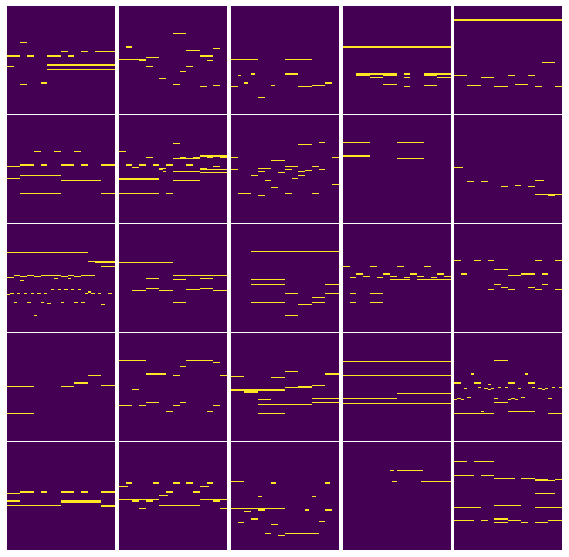

In [34]:
plt.rcParams['figure.figsize']=(10,10)

n=5

idx_all=np.arange(ins.shape[0])
idxs=np.random.choice(idx_all,n*n,replace=False)
fig,axs=plt.subplots(nrows=n,ncols=n)
count=-1
for i in range(n):
    for j in range(n):
        count+=1
        axs[i,j].imshow(ins[idxs[count],:,:,0].reshape((96,96)))
        axs[i,j].axis('off')
        
plt.subplots_adjust(wspace=0.01,hspace=0.01)

# First let's compare the verbosity of both 

In [42]:
notes_per_gen_song=[] #technically this won't be notes, instead it'll be pixels with a value of 1

for i in range(generated_plots_clipped.shape[0]):
    
    lit_pixels=0
    
    for j in range(generated_plots_clipped.shape[1]):
        for k in range(generated_plots_clipped.shape[2]):
            for m in range(generated_plots_clipped.shape[3]):
                
                check_pixel=generated_plots_clipped[i,j,k,m]
                
                if check_pixel==1:
                    lit_pixels+=1
                    
    notes_per_gen_song.append(lit_pixels)
    

In [43]:
notes_per_real_song=[]

for i in range(ins.shape[0]):
    
    lit_pixels=0
    
    for j in range(ins.shape[1]):
        for k in range(ins.shape[2]):
            for m in range(ins.shape[3]):
                
                check_pixel=ins[i,j,k,m]
                
                if check_pixel==1:
                    lit_pixels+=1
                    
    notes_per_real_song.append(lit_pixels)

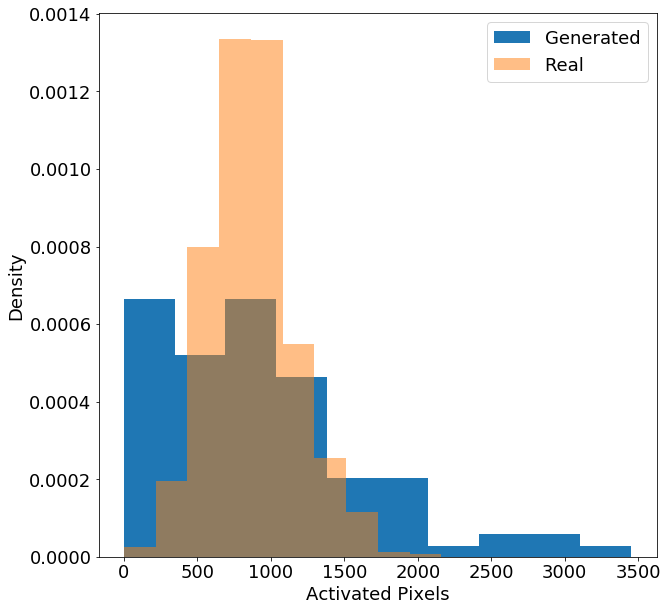

In [47]:
plt.hist(notes_per_gen_song,label='Generated',density=True)
plt.hist(notes_per_real_song,alpha=0.5,label='Real',density=True)
plt.xlabel('Activated Pixels')
plt.ylabel('Density')
plt.legend(loc='best')

In [35]:
from sklearn.neighbors import NearestNeighbors

In [48]:
#only consider the first channel
generated_plots_cut=generated_plots[:,:,:,0]
ins_cut=ins[:,:,:,0]

print(generated_plots_cut.shape)
print(ins_cut.shape)

(100, 96, 96)
(3012, 96, 96)


In [49]:
#need to unravel the images to go from shape
#[n_samples,96,96] to 
#[s_samples,96*96]
#so it has the correct shape of [n_samples,n_features]

generated_X=generated_plots_cut.reshape((generated_plots_cut.shape[0],96*96))
ins_X=ins_cut.reshape((ins_cut.shape[0],96*96))

print(generated_X.shape)
print(ins_X.shape)

(100, 9216)
(3012, 9216)


In [50]:
#these are the indexes in ins that give the nearest neighbor to each generated image
#len(idxs)=generated_plots.shape[0]

neigh = NearestNeighbors(n_neighbors=1)

idxs=[]

for i in range(10):
    
    #define an X with the generated image in the 0th index and all of the training images following it
    # X shape = [ins.shape[0]+1,96*96]
    
    X=np.zeros((ins_X.shape[0]+1,96*96))
    X[0,:]=generated_X[i,:]
    X[1:,:]=ins_X
    neigh.fit(X,y=0)
    idx=neigh.kneighbors(return_distance=False)
    print(idx[0][0])
    idxs.append(idx[0][0])

751
751
751
751
752
751
751
2697
751
2743


In [51]:
print(idxs)

[751, 751, 751, 751, 752, 751, 751, 2697, 751, 2743]


# Plot generated image - nearest neighbor pairs

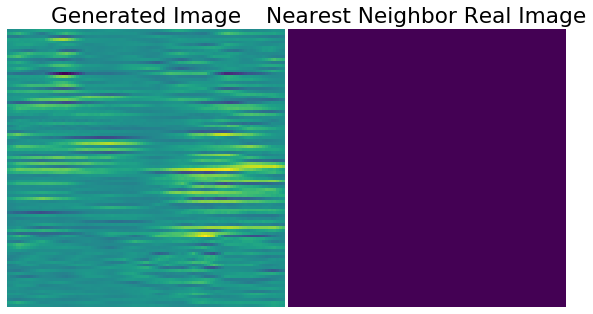

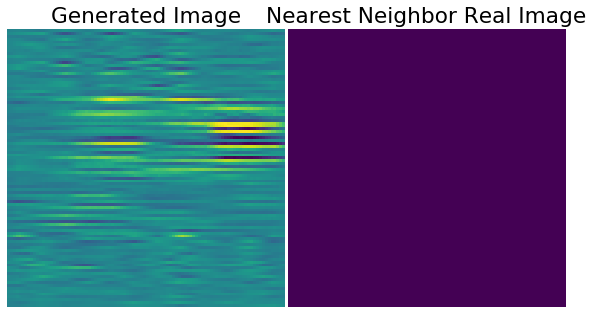

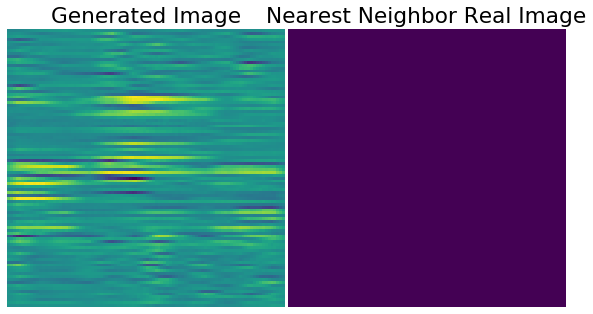

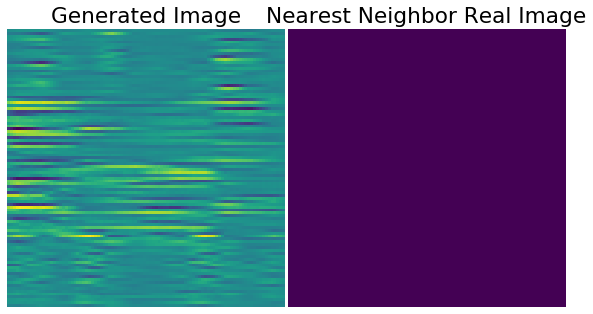

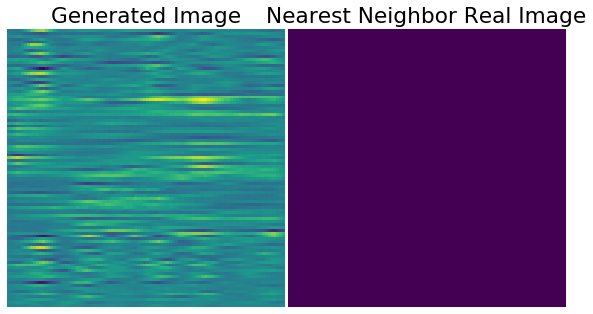

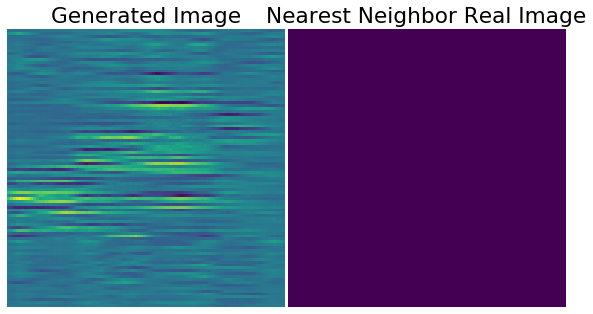

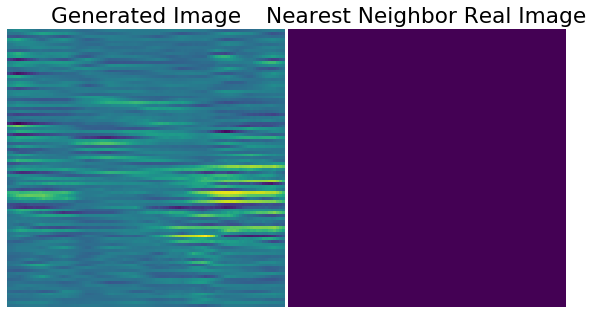

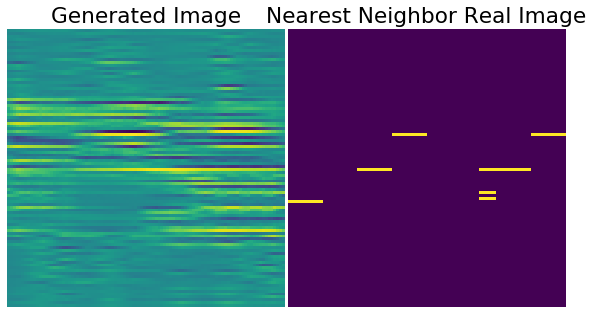

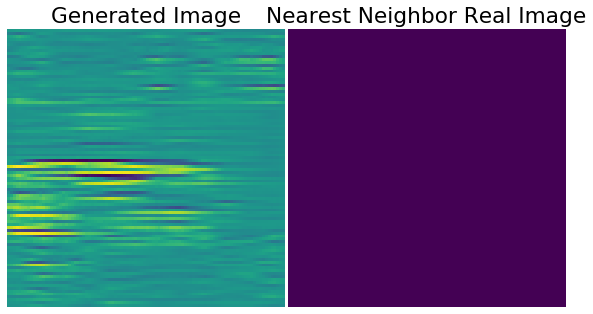

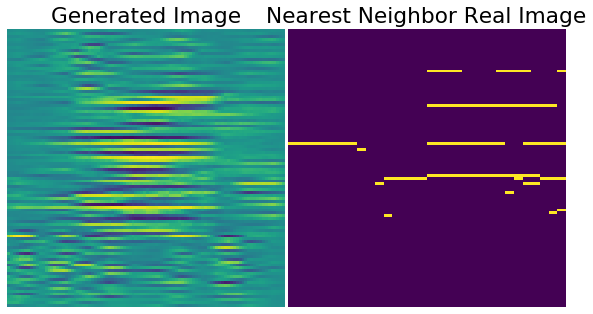

In [52]:
for i in range(10):
    fig,axs=plt.subplots(nrows=1,ncols=2)
    axs[0].imshow(generated_plots_cut[i,:,:])
    axs[0].set_title("Generated Image")
    axs[0].axis('off')
    
    idx=idxs[i]
    axs[1].imshow(ins_cut[idx,:,:])
    axs[1].set_title('Nearest Neighbor Real Image')
    axs[1].axis('off')
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.show()